In [16]:
import numpy as np
import re
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import sys
import datetime
import time
import requests
from lxml import html
from functools import wraps
%matplotlib inline

<b>Скачаем цитаты из http://www.quotationspage.com/mqotd/archive.html и сохраним в файл</b>

In [6]:
quotes = []
url = "http://www.quotationspage.com/mqotd/{}-{}-{}.html"
date = datetime.datetime(year=2004, month=1, day=1)
today = datetime.datetime.now()
pages_per_sec = 5
sleep_time = 1. / pages_per_sec


def throttler(f):
    @wraps(f)
    def throttle(*args, **kwargs):
        start_time = time.time()
        f(*args, **kwargs)
        time.sleep(max(0, sleep_time - time.time() + start_time))
    return throttle


@throttler
def get_quotes_from_page(url):
    page = requests.get(url)
    tree = html.fromstring(page.content)
    quotes.extend([x.text for x in tree.xpath('//dt[@class="quote"]/a')])


while (date + datetime.timedelta(days=1) < today):
    get_quotes_from_page(url.format(date.year, date.month, date.day))
    sys.stdout.write("get until date {}-{}-{}\r".format(date.year, date.month, date.day))
    date += datetime.timedelta(days=1)

In [10]:
quotes = set(quotes)
print(len(quotes))
with open('quotes.txt', 'w') as f:
    for quote in quotes:
        if quote is not None:
            f.write(quote.encode('utf-8') + '\n')

4377


<b>Скачаем из файла и отберём только цитаты меньше 200 симолов</b>

In [21]:
text = open('quotes.txt').read()
quotes = text.split('\n')

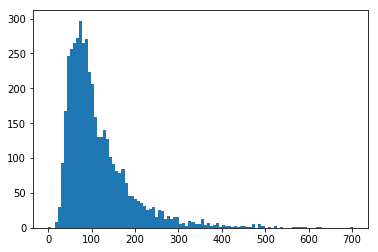

In [23]:
plt.hist(map(len, quotes), bins=100);

In [24]:
lines = filter(lambda x: len(x) <= 200, quotes)

<b>Закодируем числами все встречающиеся символы + 2 вспомогательных - начало и конец цитаты</b>

In [27]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            all_characters |= set(line)
        all_characters = list(all_characters)+['<eos>', '<go>']
        self.char_to_id = {x[1]:x[0] for x in enumerate(all_characters)}
        self.id_to_char = {x[0]:x[1] for x in enumerate(all_characters)}
        self.size = len(all_characters)

    def encode(self, line):
        return np.array([self.char_to_id[x] for x in line])
    
    def decode(self, tokens):
        return ''.join([self.id_to_char[x] for x in tokens])

In [28]:
vocab = Vocabulary(lines)

<b>Определим даталоадер примеров для сети</b>

In [30]:
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        self.sentences = sentences
        self.vocab = vocab
        
    def __len__(self):
        return len(self.sentences)
        
    def __getitem__(self, idx):
        input = self.vocab.encode(['<go>'] + list(self.sentences[idx]))
        output = self.vocab.encode(list(self.sentences[idx])+['<eos>'])
        return input, output

In [31]:
dataset = Quotes(lines, vocab)

In [32]:
dataloader = DataLoader(dataset, shuffle=True)

<b>Определим структуру по примеру https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb - <br>
    1) на входе слой ембеддинга, который возвращает внутренние представления цитат заданной размерности<br>
    2) рекуррентная сеть - цель - запоминать связи букв и возвращать их в некотором численном выражении<br>
    3) линейный слой - из выхода предыдущего слоя определяет значения классов букв (следующей буквы) - в генерации из этих значений с помощью софтмакс считаются вероятности следования букв. Генерируется наиболее вероятная буква (можно брать рандомную из некоторого количества наиболее вероятных)
</b>

In [40]:
class Oracle(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super(Oracle, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.generator = nn.GRU(embedding_size, hidden_size, layers, batch_first=True)
        self.classifier = nn.Linear(hidden_size, vocabulary_size)
    
    def forward(self, input):
        embedding = self.embedding(input)
        h = Variable(torch.zeros(self.layers, 1, self.hidden_size))
        output, _ = self.generator(embedding, (h))
        classes = self.classifier(output[0])
        return classes
    
    def generate(self, vocab, max_len=200):
        h = Variable(torch.zeros(self.layers, 1, self.hidden_size))
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and len(line) < max_len:
            token = torch.Tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = Variable(token, volatile=True)
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_val = classes.data.numpy().reshape(-1)
            classes_prob = np.exp(classes_val) / np.sum(np.exp(classes_val))
            new_token_id = np.random.choice(classes_prob.shape[0], p=classes_prob, size=1)[0]
            # new_token_id = np.argmax(classes.data.numpy()) # <- here
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token
        return line

In [41]:
oracle = Oracle(vocab.size, embedding_size=32, hidden_size=64, layers=2)

<b>Обучаем модель. Главная задача модели научиться предсказывать следующие буквы. В качестве лосса используем CrossEntropyLoss</b>

In [46]:
optimizer = torch.optim.Adam(oracle.parameters(), lr=0.01, betas=(0.1, 0.999))

In [47]:
criterion = nn.CrossEntropyLoss()

In [48]:
losses = []

In [49]:
lr_reducer = ReduceLROnPlateau(optimizer, min_lr=1e-5)

In [50]:
for epoch in xrange(50):
    local_losses = []
    for i, (batch, target) in enumerate(dataloader):
        batch = Variable(batch)
        target = Variable(target, requires_grad=False)[0]
        prediction = oracle(batch)
        loss = criterion(prediction, target)
        loss.backward()
        if i%32 == 0: # aka batch
            optimizer.step()
            oracle.zero_grad()
            losses.append(loss.data[0])
            local_losses.append(loss.data[0])
            # print loss.data[0], oracle.generate(vocab)
    epoch_loss = np.mean(local_losses)
    lr_reducer.step(epoch_loss)
    print 'epoch={} loss={} {}'.format(epoch, epoch_loss, oracle.generate(vocab))

/home/denis/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if sys.path[0] == '':
/home/denis/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  del sys.path[0]
/home/denis/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


epoch=0 loss=2.18091654778 The liik,.<eos>
epoch=1 loss=1.69869446754 I people and ourselvered enaven at what I what what touth all to rarting, and it.<eos>
epoch=2 loss=1.55468773842 It's but til talkew in ttakenings gives.<eos>
epoch=3 loss=1.50465202332 Those one dallolent you don't pertaked of con, a good and the fubting what I mustle meads is nothing and thyself. Something ecers refuse - Andorail, moud the elsed if is to choortun, all badive I must
epoch=4 loss=1.45707094669 I be cuory, really sacking het a defear in to be people and not thyuase that we charing fear sail.<eos>
epoch=5 loss=1.46107697487 Ache right he is an allows about but well into super oursab, fruit you aren its badicuce some, evises it periage.<eos>
epoch=6 loss=1.45941233635 Entrankly ong is the pracite raintripe his just cinds succe't great that your of a great my incan art of all 15 kindth has not gonese of even the wisiful is to will into days. Happit unthing anywacty 
epoch=7 loss=1.40533792973 Cometal o

oracle.generate(vocab)

<b>Loss модели</b>

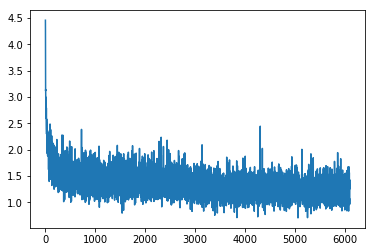

In [54]:
plt.plot(losses)